In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio

import pandas as pd

import os

In [2]:
path_ds = '/home/edoardobucheli/Datasets/freesound-audio-tagging-2019/'
path_train_curated = os.path.join(path_ds,'train_curated')

In [3]:
df_train = pd.read_csv(os.path.join(path_ds,'train_curated.csv'))

In [4]:
df_train.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [5]:
batch_size = 64
sr=44100

In [6]:
names = df_train['fname'].tolist()
names_paths = [os.path.join(path_train_curated,f) for f in names]

labels = df_train['labels'].tolist()

In [7]:
def log10(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

In [317]:
def preprocess_wave(file):
    
    twenty = tf.constant(20,dtype = tf.float32)
    zero = tf.constant(0,dtype = tf.float32)
    rate = tf.constant(44100, dtype = tf.int32)
    one = tf.constant(1,dtype = tf.int32)
    zeroint = tf.constant(0,dtype = tf.int32)
    wave,rate = tf.audio.decode_wav(file, desired_channels = 1, desired_samples = -1)
    size1 = tf.shape(wave)[0]
    diff = rate-size1
    diff = tf.cond(diff < 0, lambda:0,lambda:diff)
    
    pad = tf.zeros((diff,1))
    wave = tf.concat((wave,pad),axis=0)
    size2 = tf.shape(wave)[0]
    max_start = size2-rate+1

    start = tf.random_uniform((), minval=0, maxval=max_start, dtype=tf.int32, seed=None, name=None)

    x = wave[start:start+44100,:]
    x = tf.expand_dims(x,axis = 0)
    x = tf.squeeze(x,axis = -1)
    x = x/tf.reduce_max(tf.abs(x),axis = 1)

    X = tf.signal.stft(x,frame_length=512, frame_step = 256, fft_length = 1024)
    mX = twenty*log10(tf.abs(X))
    pX = tf.angle(X)
    
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins = 40,
                                                       num_spectrogram_bins=513,
                                                       sample_rate = 44100,
                                                       lower_edge_hertz=125,
                                                       upper_edge_hertz=16000)
    mel_S = tf.matmul(mX,mel_matrix)
    
    melmin = tf.reduce_min(mel_S)
    melmax = tf.reduce_max(mel_S)
    half_len = (melmax-melmin)/2
    melmid = melmin+half_len
    
    mel_S -= melmid
    mel_S /= tf.reduce_max(tf.abs(mel_S))
    
    return x,mX,pX,mel_S

In [318]:
def load_and_preprocess_wav(path):
    file = tf.read_file(path)
    return preprocess_wave(file)

In [319]:
wave_path_ds = tf.data.Dataset.from_tensor_slices(names_paths)

In [320]:
wave_ds = wave_path_ds.map(load_and_preprocess_wav)
wave_ds = wave_ds.batch(batch_size)

In [321]:
wave_ds

<DatasetV1Adapter shapes: ((?, 1, ?), (?, 1, ?, 513), (?, 1, ?, 513), (?, 1, ?, 40)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

In [322]:
iterator = wave_ds.make_initializable_iterator()
next_element = iterator.get_next()

In [323]:
sess = tf.Session()
sess.run(iterator.initializer)

In [324]:
this_wave,this_mX,this_pX, this_mel_S = sess.run(next_element)

28


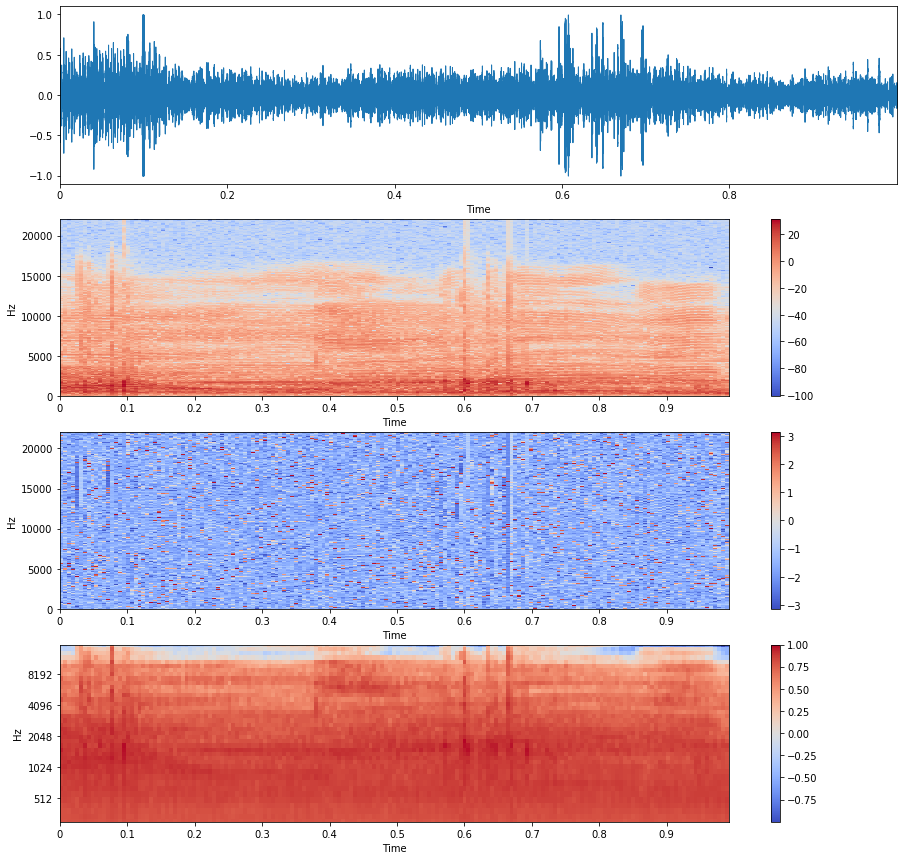

In [337]:
n = np.random.randint(0,64)
#n=7
print(n)
plt.figure(figsize = (15,15))
plt.subplot(4,1,1)
librosa.display.waveplot(this_wave[n].squeeze(0),sr = sr)
plt.subplot(4,1,2)
librosa.display.specshow(this_mX[n].squeeze(0).T,x_axis='time',y_axis='linear',sr=sr,hop_length=256)
plt.colorbar()
plt.subplot(4,1,3)
librosa.display.specshow(np.diff(np.unwrap(this_pX[n].squeeze(0),axis=1),axis=1).T,x_axis='time',y_axis='linear',sr=sr,hop_length=256)
plt.colorbar()
plt.subplot(4,1,4)
librosa.display.specshow(this_mel_S[n].squeeze(0).T,sr=sr,x_axis = 'time',y_axis = 'mel',fmin=125,fmax=16000,hop_length=256)
plt.colorbar()

In [338]:
print(labels[n])
Audio(this_wave[n].squeeze(0),rate = sr)

Cheering,Clapping
